In [1]:
# =====================================================
# 1. Initialization: Time and System Parameters
# =====================================================
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt

# Time settings
control_horizon = 1
prediction_horizon = 12
T_total = 168  # 1 week, 1-hour resolution

# System parameters
eta_ch = 0.95
eta_dch = 0.95
eta_elec = 0.7

SOC_max = 1000
P_bat_max = 200
P_elec_max = 300
H_store_max = 1000

# Cost and price parameters
C_grid_base = 40
C_battery = 1
C_elec = 1
C_Hstore = 0.1
H_price = 10
CO2_tax = 40  

# Initial states
SOC_real = [500]         # Battery not empty or full
H_store_real = [300]     # Hydrogen storage partially filled


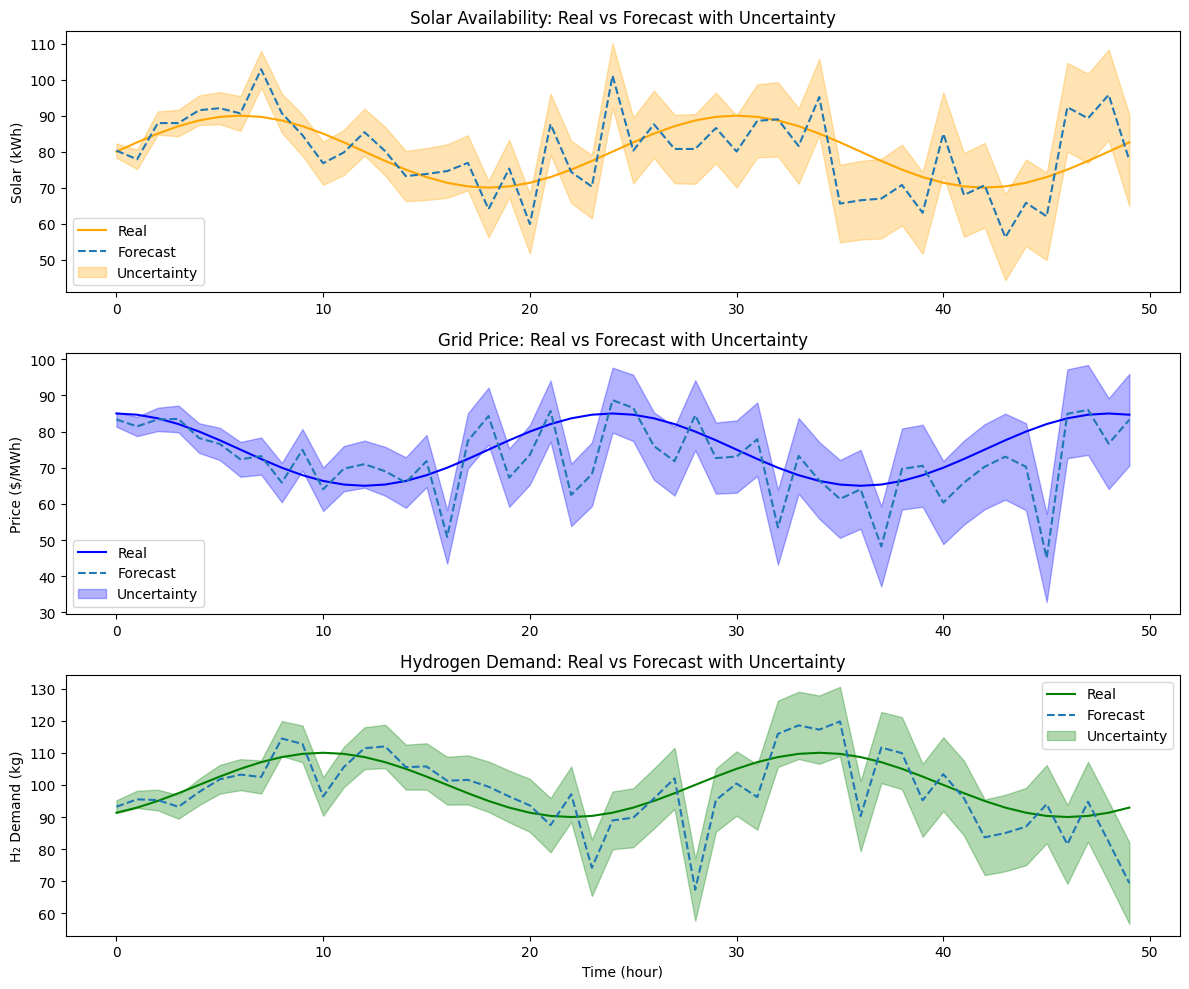

In [2]:
# =====================================================
# 2. Forecast & Real-Time Models + Visualization
# =====================================================
sigma0 = 2
alpha = 0.8

def real_solar(t):
    return 100 * (0.8 + 0.1 * np.sin(2 * np.pi * t / 24))

def real_grid_price(t):
    return 75 + 10 * np.cos(2 * np.pi * t / 24)

def real_hydrogen_demand(t):
    return 100 + 10 * np.sin(2 * np.pi * t / 24 - np.pi / 3)

def forecast_with_uncertainty(real_func, t, delta):
    std = sigma0 * np.sqrt(1 + alpha * delta)
    value = real_func(t) + np.random.normal(0, std)
    return value, std


# Visualize real vs forecast with uncertainty bands
t_vis = np.arange(50)

# Containers
solar_real, solar_forecast, solar_upper, solar_lower = [], [], [], []
grid_real, grid_forecast, grid_upper, grid_lower = [], [], [], []
hydrogen_real, hydrogen_forecast, hydrogen_upper, hydrogen_lower = [], [], [], []

for ti in t_vis:
    real_s = real_solar(ti)
    f_s, std_s = forecast_with_uncertainty(real_solar, ti, ti)
    solar_real.append(real_s)
    solar_forecast.append(f_s)
    solar_upper.append(f_s + std_s)
    solar_lower.append(f_s - std_s)

    real_g = real_grid_price(ti)
    f_g, std_g = forecast_with_uncertainty(real_grid_price, ti, ti)
    grid_real.append(real_g)
    grid_forecast.append(f_g)
    grid_upper.append(f_g + std_g)
    grid_lower.append(f_g - std_g)

    real_h = real_hydrogen_demand(ti)
    f_h, std_h = forecast_with_uncertainty(real_hydrogen_demand, ti, ti)
    hydrogen_real.append(real_h)
    hydrogen_forecast.append(f_h)
    hydrogen_upper.append(f_h + std_h)
    hydrogen_lower.append(f_h - std_h)


# Plot with separate rows
plt.figure(figsize=(12, 10))

# Solar
plt.subplot(3, 1, 1)
plt.plot(t_vis, solar_real, label='Real', color='orange')
plt.plot(t_vis, solar_forecast, '--', label='Forecast')
plt.fill_between(t_vis, solar_lower, solar_upper, color='orange', alpha=0.3, label='Uncertainty')
plt.title("Solar Availability: Real vs Forecast with Uncertainty")
plt.ylabel("Solar (kWh)")
plt.legend()

# Grid Price
plt.subplot(3, 1, 2)
plt.plot(t_vis, grid_real, label='Real', color='blue')
plt.plot(t_vis, grid_forecast, '--', label='Forecast')
plt.fill_between(t_vis, grid_lower, grid_upper, color='blue', alpha=0.3, label='Uncertainty')
plt.title("Grid Price: Real vs Forecast with Uncertainty")
plt.ylabel("Price ($/MWh)")
plt.legend()

# Hydrogen Demand
plt.subplot(3, 1, 3)
plt.plot(t_vis, hydrogen_real, label='Real', color='green')
plt.plot(t_vis, hydrogen_forecast, '--', label='Forecast')
plt.fill_between(t_vis, hydrogen_lower, hydrogen_upper, color='green', alpha=0.3, label='Uncertainty')
plt.title("Hydrogen Demand: Real vs Forecast with Uncertainty")
plt.xlabel("Time (hour)")
plt.ylabel("H₂ Demand (kg)")
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
# =====================================================
# 3. MPC Loop (Updated with Param Fix)
# =====================================================
logs = {k: [] for k in ["E_sb", "E_be", "E_ge", "P_elec", "H_prod", "H_sales","H_es","H_est","H_hs","H_ss", "SOC", "H_store","solar"]}

for current_time in range(T_total):


    model = pyo.ConcreteModel()
    model.T = pyo.RangeSet(0, prediction_horizon - 1)

    # Forecasts
    grid_price = [forecast_with_uncertainty(real_grid_price, current_time, t)[0] for t in model.T]
    H_demand   = [forecast_with_uncertainty(real_hydrogen_demand, current_time, t)[0] for t in model.T]
    
    # Use Param for solar forecast
    model.solar_avail = pyo.Param(
        model.T,
        initialize={t: forecast_with_uncertainty(real_solar, current_time, t)[0] for t in model.T},
        mutable=True
    )

    # Decision Variables
    model.E_sb = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_be = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.E_ge = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_es = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_est = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_ss = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.H_hs = pyo.Var(model.T, within=pyo.NonNegativeReals)
    model.SOC = pyo.Var(model.T, within=pyo.NonNegativeReals)

    # Expressions
    def P_elec_expr(m, t):
        return m.solar_avail[t] - m.E_sb[t] + m.E_be[t] + m.E_ge[t]
    model.P_elec = pyo.Expression(model.T, rule=P_elec_expr)
    model.H_prod = pyo.Expression(model.T, rule=lambda m, t: eta_elec * m.P_elec[t])
    model.H_sales = pyo.Expression(model.T, rule=lambda m, t: m.H_es[t] + m.H_ss[t])

    model.constraints = pyo.ConstraintList()
    for t in model.T:
        model.constraints.add(model.P_elec[t] <= P_elec_max)
        model.constraints.add(model.E_sb[t] <= P_bat_max)
        model.constraints.add(model.E_be[t] <= P_bat_max)
        model.constraints.add(model.H_prod[t] == model.H_es[t] + model.H_est[t])
        model.constraints.add(model.H_sales[t] <= H_demand[t])
        model.constraints.add(model.H_es[t] <= model.H_prod[t])
        model.constraints.add(model.H_ss[t] <= model.H_hs[t])
        model.constraints.add(model.H_hs[t] <= H_store_max)
        model.constraints.add(model.SOC[t] <= SOC_max)

        if t == 0:
            model.constraints.add(model.SOC[t] == SOC_real[-1] + eta_ch * model.E_sb[t] - model.E_be[t] / eta_dch)
            model.constraints.add(model.H_hs[t] == H_store_real[-1] + model.H_est[t] - model.H_ss[t])
        else:
            model.constraints.add(model.SOC[t] == model.SOC[t-1] + eta_ch * model.E_sb[t] - model.E_be[t] / eta_dch)
            model.constraints.add(model.H_hs[t] == model.H_hs[t-1] + model.H_est[t] - model.H_ss[t])

    # Objective Function
    model.obj = pyo.Objective(
        expr=sum((grid_price[t] + CO2_tax) * model.E_ge[t] +
                 C_battery * (model.E_sb[t] + model.E_be[t]) +
                 C_elec * model.P_elec[t] +
                 C_Hstore * model.H_hs[t] -
                 H_price * model.H_sales[t] for t in model.T),
        sense=pyo.minimize
    )

    # Solve
    solver = pyo.SolverFactory('cbc')
    results = solver.solve(model, tee=False)

    if results.solver.termination_condition != pyo.TerminationCondition.optimal:
        print(f"MPC solve failed at t={current_time}")
        break

    # Apply first control step
    E_sb_now = model.E_sb[0]()
    E_be_now = model.E_be[0]()
    E_ge_now = model.E_ge[0]()
    P_elec_now = model.P_elec[0]()
    H_prod_now = model.H_prod[0]()
    H_sales_now = model.H_sales[0]()
    H_est_now = model.H_est[0]()
    H_est = model.H_est[0]()
    H_ss_now = model.H_ss[0]()
    H_es = model.H_es[0]()
    solar_nn=model.solar_avail[0]()

    # Update states
    SOC_new = SOC_real[-1] + eta_ch * E_sb_now - E_be_now / eta_dch
    H_store_new = H_store_real[-1] + H_est_now - H_ss_now
    SOC_real.append(SOC_new)
    H_store_real.append(H_store_new)

    # Log results
    logs["E_sb"].append(E_sb_now)
    logs["E_be"].append(E_be_now)
    logs["E_ge"].append(E_ge_now)
    logs["P_elec"].append(P_elec_now)
    logs["H_prod"].append(H_prod_now)
    logs["H_sales"].append(H_sales_now)
    logs["SOC"].append(SOC_real[-2])
    logs["H_store"].append(H_store_real[-2])
    logs["solar"].append(solar_nn)
    logs["H_es"].append(H_es)
    logs["H_est"].append(H_est)
    logs["H_ss"].append(H_ss_now)


In [4]:
time = np.arange(len(logs["E_sb"]))
real_demand = np.array([real_hydrogen_demand(t) for t in time])
real_solar = np.array([real_solar(t) for t in time])

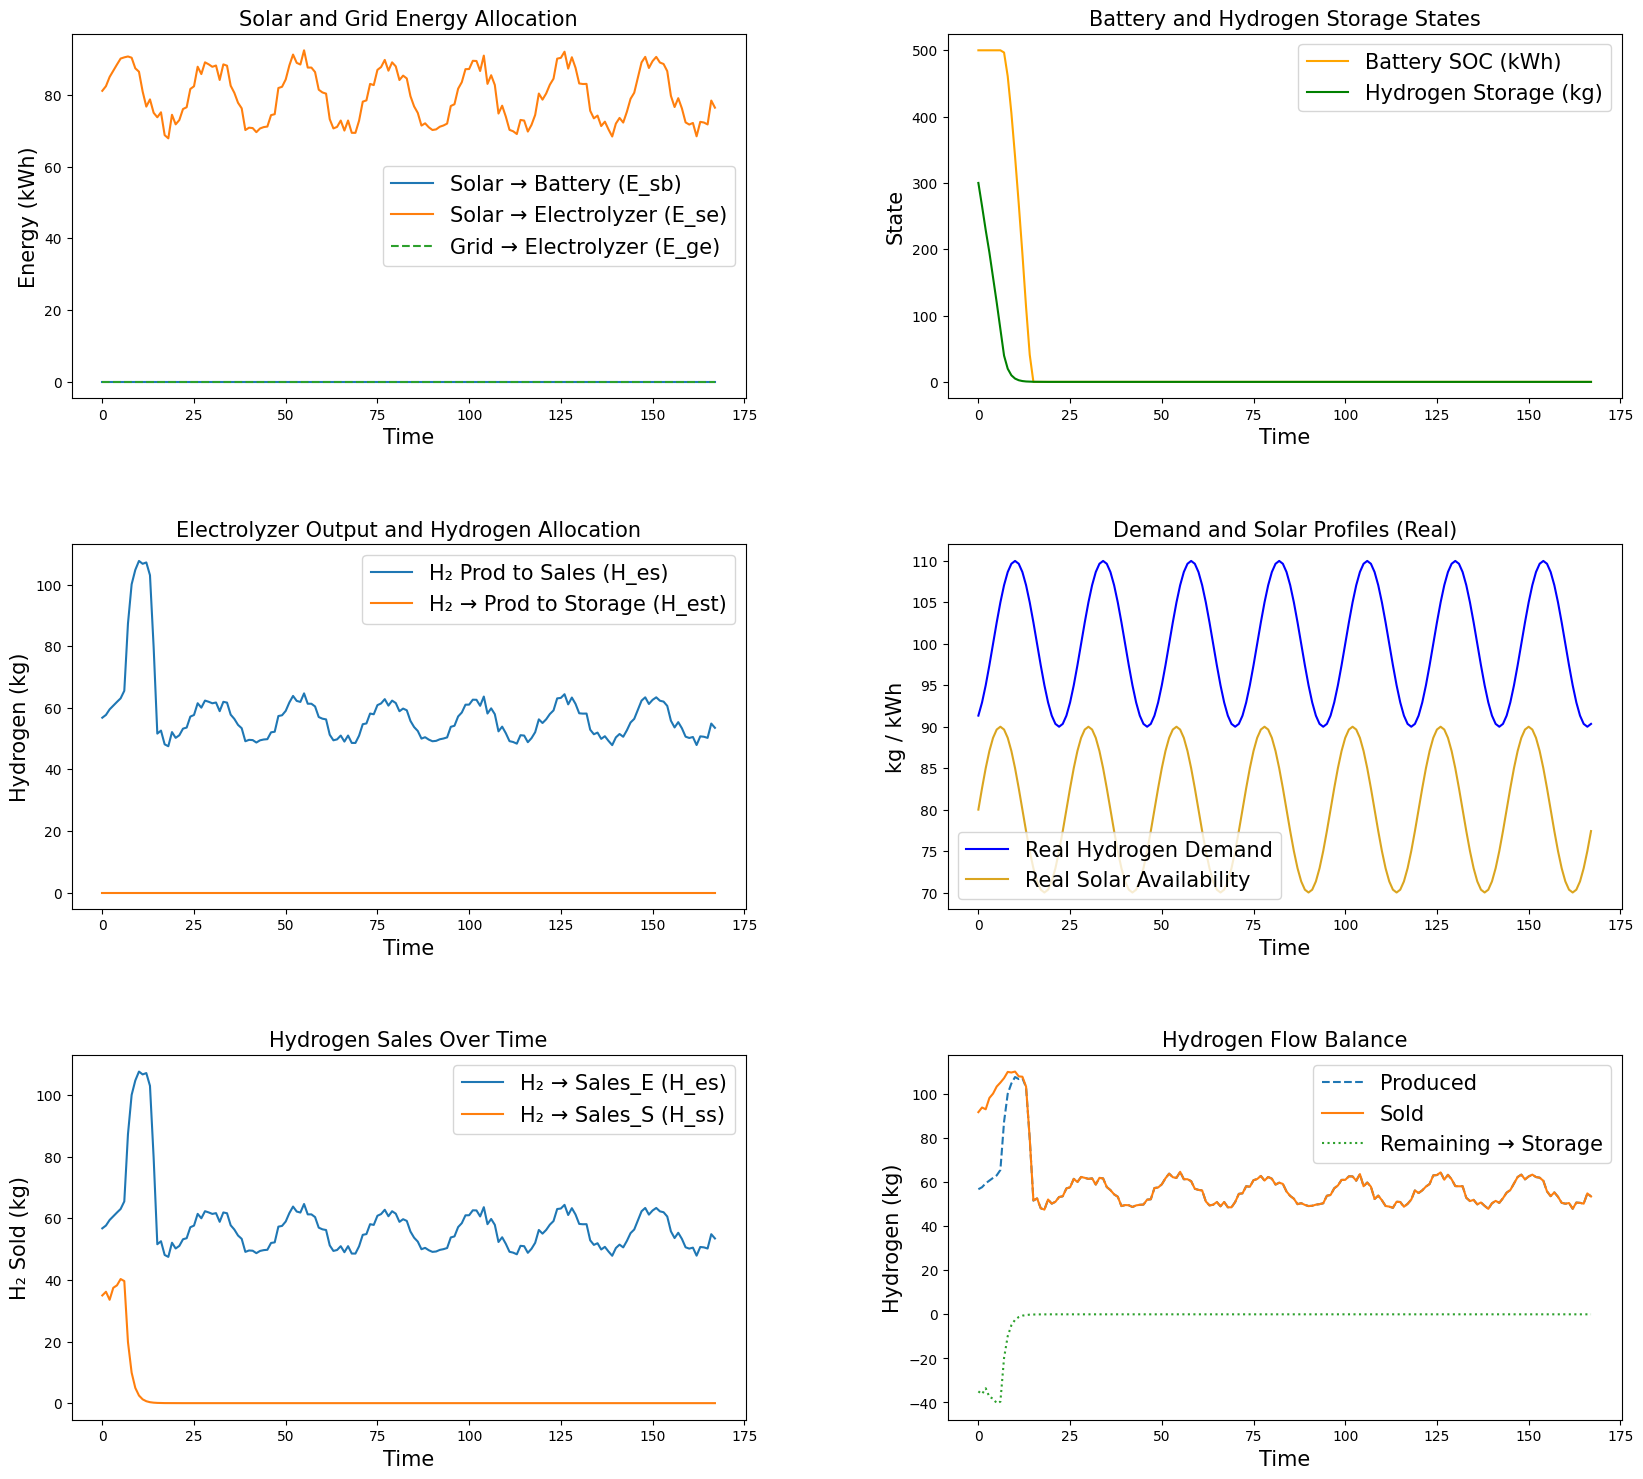

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Extract from logs
time = np.arange(len(logs["E_sb"]))
E_sb = np.array(logs["E_sb"])
E_be = np.array(logs["E_be"])
E_ge = np.array(logs["E_ge"])
P_elec = np.array(logs["P_elec"])
H_prod = np.array(logs["H_prod"])
H_es = np.array(logs["H_es"])
H_est = np.array(logs["H_est"])
H_sales = np.array(logs["H_sales"])
SOC = np.array(logs["SOC"])
H_store = np.array(logs["H_store"])
H_ss = np.array(logs["H_ss"])
solar = np.array(logs["solar"])


# Font size
font_size = 15  # 1.5x of typical default (usually 12)

# Start figure
fig, axs = plt.subplots(3, 2, figsize=(20, 18))
axs = axs.ravel()

# 1. Solar energy allocation
axs[0].plot(time, E_sb, label='Solar → Battery (E_sb)')
axs[0].plot(time, solar - E_sb, label='Solar → Electrolyzer (E_se)')
axs[0].plot(time, E_ge, label='Grid → Electrolyzer (E_ge)', linestyle='--')
axs[0].set_title("Solar and Grid Energy Allocation", fontsize=font_size)
axs[0].set_ylabel("Energy (kWh)", fontsize=font_size)
axs[0].set_xlabel("Time", fontsize=font_size)
axs[0].legend(fontsize=font_size)

# 2. Battery and Hydrogen Storage
axs[1].plot(time, SOC, label='Battery SOC (kWh)', color='orange')
axs[1].plot(time, H_store, label='Hydrogen Storage (kg)', color='green')
axs[1].set_title("Battery and Hydrogen Storage States", fontsize=font_size)
axs[1].set_ylabel("State", fontsize=font_size)
axs[1].set_xlabel("Time", fontsize=font_size)
axs[1].legend(fontsize=font_size)

# 3. Electrolyzer Output and Distribution
axs[2].plot(time, H_es, label='H₂ Prod to Sales (H_es)')
axs[2].plot(time, H_est, label='H₂ → Prod to Storage (H_est)')
axs[2].set_title("Electrolyzer Output and Hydrogen Allocation", fontsize=font_size)
axs[2].set_ylabel("Hydrogen (kg)", fontsize=font_size)
axs[2].set_xlabel("Time", fontsize=font_size)
axs[2].legend(fontsize=font_size)

# 4. Demand and Solar Profiles
axs[3].plot(time, real_demand, label='Real Hydrogen Demand', color='blue')
axs[3].plot(time, real_solar, label='Real Solar Availability', color='goldenrod')
axs[3].set_title("Demand and Solar Profiles (Real)", fontsize=font_size)
axs[3].set_ylabel("kg / kWh", fontsize=font_size)
axs[3].set_xlabel("Time", fontsize=font_size)
axs[3].legend(fontsize=font_size)

# 5. Hydrogen Sales
axs[4].plot(time, H_es, label='H₂ → Sales_E (H_es)')
axs[4].plot(time, H_ss, label='H₂ → Sales_S (H_ss)')
axs[4].set_title("Hydrogen Sales Over Time", fontsize=font_size)
axs[4].set_ylabel("H₂ Sold (kg)", fontsize=font_size)
axs[4].set_xlabel("Time", fontsize=font_size)
axs[4].legend(fontsize=font_size)

# 6. Hydrogen Balance
axs[5].plot(time, H_prod, label='Produced', linestyle='--')
axs[5].plot(time, H_sales, label='Sold', linestyle='-')
axs[5].plot(time, H_prod - H_sales, label='Remaining → Storage', linestyle=':')
axs[5].set_title("Hydrogen Flow Balance", fontsize=font_size)
axs[5].set_ylabel("Hydrogen (kg)", fontsize=font_size)
axs[5].set_xlabel("Time", fontsize=font_size)
axs[5].legend(fontsize=font_size)

# Adjust spacing
plt.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()


In [6]:
grid_cost = np.sum(E_ge * (C_grid_base + CO2_tax))
battery_cost = np.sum(C_battery * (E_sb + E_be))
electrolyzer_cost = np.sum(C_elec * P_elec)
storage_cost = np.sum(C_Hstore * H_store)
total_cost = grid_cost + battery_cost + electrolyzer_cost + storage_cost

In [7]:
import numpy as np

# Convert lists to numpy arrays if needed
E_sb = np.array(logs["E_sb"])
E_be = np.array(logs["E_be"])
E_ge = np.array(logs["E_ge"])
P_elec = np.array(logs["P_elec"])
H_prod = np.array(logs["H_prod"])
H_sales = np.array(logs["H_sales"])
H_es = np.array(logs["H_es"])
H_ss = np.array(logs["H_ss"])
H_est = np.array(logs["H_est"])
H_store = np.array(logs["H_store"])

# Cost and price parameters
C_grid_base = 40
C_battery = 1
C_elec = 1
C_Hstore = 0.1
H_price = 10
CO2_tax = 40

# === ENERGY METRICS ===
solar_to_battery = np.sum(E_sb)
solar_to_electrolyzer = np.sum(P_elec - E_be - E_ge)  # Approx solar used
battery_discharge = np.sum(E_be)
grid_energy = np.sum(E_ge)
electrolyzer_energy = np.sum(P_elec)

# === HYDROGEN METRICS ===
hydrogen_produced = np.sum(H_prod)
hydrogen_sold_total = np.sum(H_sales)
hydrogen_sold_from_prod = np.sum(H_es)
hydrogen_sold_from_storage = np.sum(H_ss)
hydrogen_to_storage = np.sum(H_est)

# === COSTS ===
grid_cost = np.sum(E_ge * (C_grid_base + CO2_tax))
battery_cost = np.sum(C_battery * (E_sb + E_be))
electrolyzer_cost = np.sum(C_elec * P_elec)
storage_cost = np.sum(C_Hstore * H_store)
total_cost = grid_cost + battery_cost + electrolyzer_cost + storage_cost

# === REVENUE & PROFIT ===
revenue = np.sum(H_price * H_sales)
net_profit = revenue - total_cost

# === KPI SUMMARY ===
metrics = {
    "Solar Used (E_se)": solar_to_electrolyzer,
    "Grid Energy Used (E_ge)": grid_energy,
    "Battery Charge (E_sb)": solar_to_battery,
    "Battery Discharge (E_be)": battery_discharge,
    "Electrolyzer Energy": electrolyzer_energy,
    "Hydrogen Produced": hydrogen_produced,
    "Hydrogen Sold (Total)": hydrogen_sold_total,
    "Hydrogen Sold from Production (H_es)": hydrogen_sold_from_prod,
    "Hydrogen Sold from Storage (H_ss)": hydrogen_sold_from_storage,
    "Hydrogen Sent to Storage (H_est)": hydrogen_to_storage,
    "Revenue from H₂ Sales": revenue,
    "Grid Cost": grid_cost,
    "Battery Cost": battery_cost,
    "Electrolyzer Cost": electrolyzer_cost,
    "Storage Cost": storage_cost,
    "Total Cost": total_cost,
    "Net Profit": net_profit,
    "Hydrogen Utilization (%)": 100 * hydrogen_sold_total / hydrogen_produced if hydrogen_produced > 0 else 0
}

# Optional: print as report
for k, v in metrics.items():
    print(f"{k:40s}: {v:.2f}")


Solar Used (E_se)                       : 13399.04
Grid Energy Used (E_ge)                 : 0.00
Battery Charge (E_sb)                   : 0.00
Battery Discharge (E_be)                : 475.00
Electrolyzer Energy                     : 13874.04
Hydrogen Produced                       : 9711.82
Hydrogen Sold (Total)                   : 10011.82
Hydrogen Sold from Production (H_es)    : 9711.82
Hydrogen Sold from Storage (H_ss)       : 300.00
Hydrogen Sent to Storage (H_est)        : -0.00
Revenue from H₂ Sales                   : 100118.25
Grid Cost                               : 0.00
Battery Cost                            : 475.00
Electrolyzer Cost                       : 13874.04
Storage Cost                            : 142.51
Total Cost                              : 14491.55
Net Profit                              : 85626.70
Hydrogen Utilization (%)                : 103.09


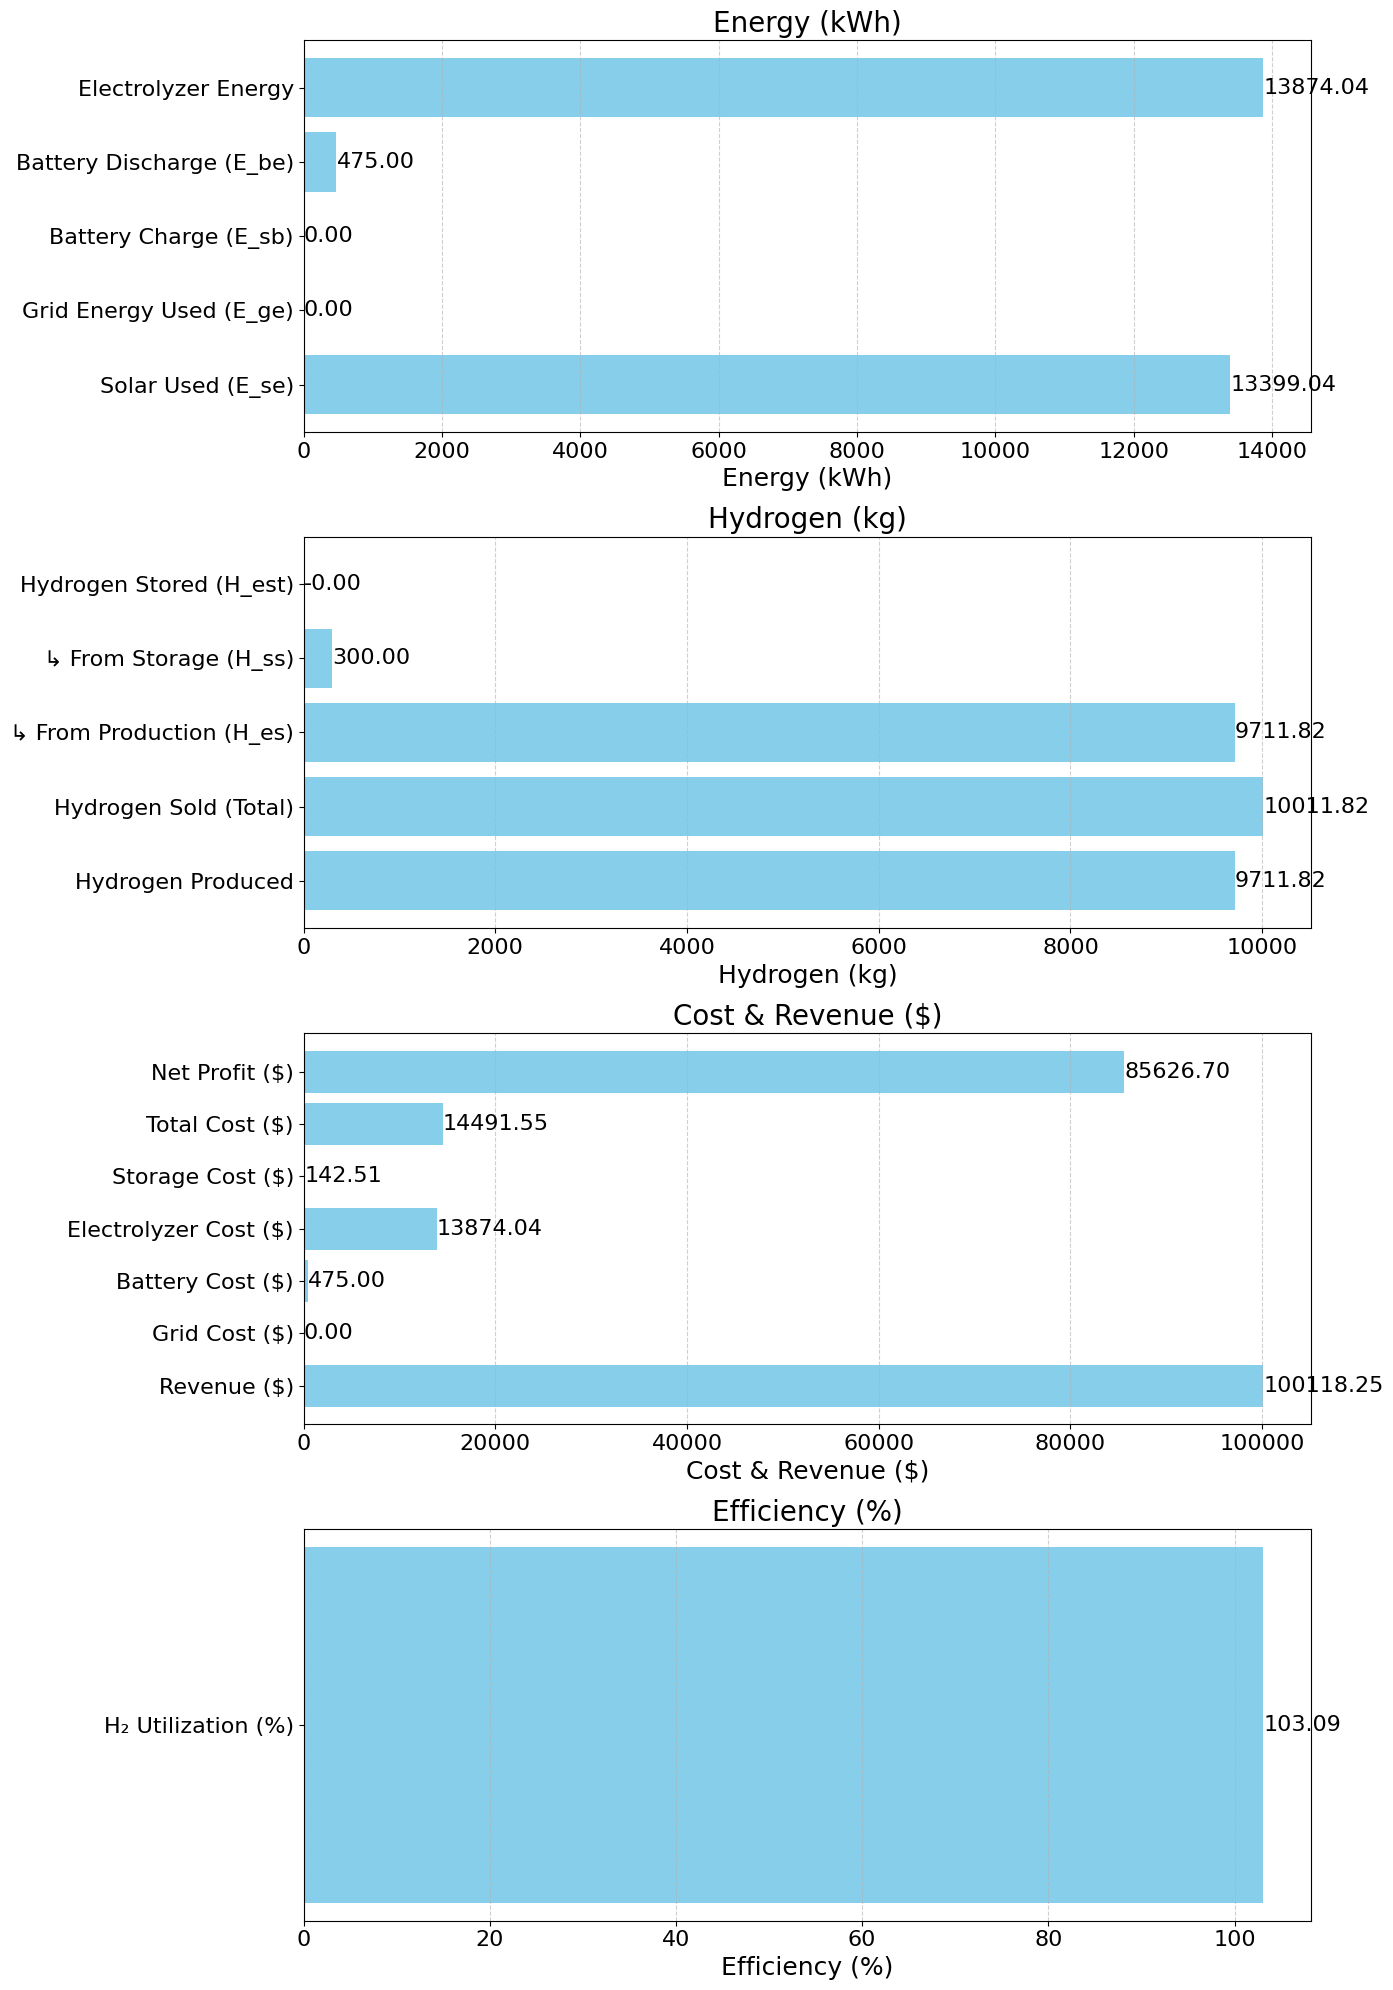

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# === Dictionary of KPI values ===
kpi_values = {
    "Solar Used (E_se)": solar_to_electrolyzer,
    "Grid Energy Used (E_ge)": grid_energy,
    "Battery Charge (E_sb)": solar_to_battery,
    "Battery Discharge (E_be)": battery_discharge,
    "Electrolyzer Energy": electrolyzer_energy,
    "Hydrogen Produced": hydrogen_produced,
    "Hydrogen Sold (Total)": hydrogen_sold_total,
    "↳ From Production (H_es)": hydrogen_sold_from_prod,
    "↳ From Storage (H_ss)": hydrogen_sold_from_storage,
    "Hydrogen Stored (H_est)": hydrogen_to_storage,
    "Revenue ($)": revenue,
    "Grid Cost ($)": grid_cost,
    "Battery Cost ($)": battery_cost,
    "Electrolyzer Cost ($)": electrolyzer_cost,
    "Storage Cost ($)": storage_cost,
    "Total Cost ($)": total_cost,
    "Net Profit ($)": net_profit,
    "H₂ Utilization (%)": 100 * hydrogen_sold_total / hydrogen_produced if hydrogen_produced > 0 else 0
}

# === Categories for subplot grouping ===
categories = {
    "Energy (kWh)": ["Solar Used (E_se)", "Grid Energy Used (E_ge)", "Battery Charge (E_sb)", "Battery Discharge (E_be)", "Electrolyzer Energy"],
    "Hydrogen (kg)": ["Hydrogen Produced", "Hydrogen Sold (Total)", "↳ From Production (H_es)", "↳ From Storage (H_ss)", "Hydrogen Stored (H_est)"],
    "Cost & Revenue ($)": ["Revenue ($)", "Grid Cost ($)", "Battery Cost ($)", "Electrolyzer Cost ($)", "Storage Cost ($)", "Total Cost ($)", "Net Profit ($)"],
    "Efficiency (%)": ["H₂ Utilization (%)"]
}

import matplotlib.pyplot as plt
import numpy as np

# === Font size settings ===
title_fontsize = 20
label_fontsize = 18
tick_fontsize = 16
value_fontsize = 16

# === Plotting with updated font sizes ===
fig, axs = plt.subplots(len(categories), 1, figsize=(14, 20))

for ax, (title, keys) in zip(axs, categories.items()):
    values = [kpi_values[k] for k in keys]
    bars = ax.barh(keys, values, color='skyblue')
    
    # Set titles and labels
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(title, fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
    # Add value labels inside bars
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height() / 2,
                f'{width:.2f}', va='center', ha='left', fontsize=value_fontsize)
    
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
